### 생선 분류 - 최적의 K값 찾기 : 하이퍼 파라미터
- 데이터셋 : fish.csv
- 피쳐/특성 : Weight, Length
- 타겟/라벨 : Species 
- 학습방법 : 지도학습 -> 분류 
- 학습알고리즘 : 최근접이웃 알고리즘 KNN
- 하이퍼 파라미터 튜닝 : 모델 성능 개선 


[1] 데이터 준비

In [160]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [161]:
DATA_FILE = '../data/fish.csv'

In [162]:
# 행 : Bream, Smelt 컬럼 : Species, Weight, Height => 0,1,2
fishDF=pd.read_csv(DATA_FILE,usecols=[0,1,2])
fishDF.head(3)

,Species,Weight,Length
0,Bream,242.0,25.4
1,Bream,290.0,26.3
2,Bream,340.0,26.5


In [163]:
mask=(fishDF['Species']=='Bream') | (fishDF['Species']=='Smelt')
twoDF=fishDF[mask]
twoDF.reset_index(drop=True, inplace=True)
twoDF.index

RangeIndex(start=0, stop=49, step=1)

In [164]:
# Species 컬럼을 수치화 => Bream:0 , Smelt:1
new_cols=twoDF.loc[:,'Species'].replace({'Bream':0, 'Smelt':1})
twoDF['FCode'] = new_cols

C:\Users\kdp\AppData\Local\Temp\ipykernel_11344\3437650817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  twoDF['FCode'] = new_cols


[2] 피쳐와 타겟분리

In [165]:
features = twoDF[['Weight','Length']]
target = twoDF['FCode']
print(f'features => {features.shape}, {features.ndim}D')
print(f'target => {target.shape}, {target.ndim}D')

features => (49, 2), 2D
target => (49,), 1D


[3] 학습용, 테스트용 데이터셋 준비 

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
# train : test = 80:20 ===> test_size = 0.2 or train_size=0.8  
# stratify 매개변수 : 분류일 경우 사용, 분류 타겟의 종류에 대한 비율을 고려    
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    stratify=target,
                                                    random_state=10)

In [168]:
# train : test = 80 : 20 Check
print(f'X_train : {X_train.shape},{X_train.ndim}D')
print(f'y_train : {y_train.shape},{y_train.ndim}D')

print(f'X_test : {X_test.shape},{X_test.ndim}D')
print(f'y_test : {y_test.shape},{y_test.ndim}D')

X_train : (39, 2),2D
y_train : (39,),1D
X_test : (10, 2),2D
y_test : (10,),1D


In [169]:
# target 0(Bream), 1(Smelt)의 비율 
y_train.value_counts()[0]/y_train.shape[0],y_train.value_counts()[1]/y_train.shape[0]

(0.717948717948718, 0.28205128205128205)

In [170]:
y_test.value_counts()[0]/y_test.shape[0],y_test.value_counts()[1]/y_test.shape[0]

(0.7, 0.3)

[3-2] 피쳐 스케일링 

In [171]:
from sklearn.preprocessing import MinMaxScaler

In [172]:
# 스케일러 인스턴스 생성
mmSclaer = MinMaxScaler()

In [173]:
# 데이터에 기반한 MinMaxSclaer 동작을 위한 학습 진행
mmSclaer.fit(X_train)

MinMaxScaler()

In [174]:
mmSclaer.min_,mmSclaer.data_min_,mmSclaer.scale_,mmSclaer.data_max_

(array([-0.00674519, -0.31410256]),
 array([6.7, 9.8]),
 array([0.00100675, 0.03205128]),
 array([1000.,   41.]))

In [175]:
X_train.max(), X_train.min()

(Weight    1000.0
 Length      41.0
 dtype: float64,
 Weight    6.7
 Length    9.8
 dtype: float64)

In [176]:
# 학습용 데이터셋 ==> 스케일링 ==> ndarray 타입
X_train_scaled=mmSclaer.transform(X_train)
X_train_scaled.shape, X_train_scaled.min(),X_train_scaled.max()

((39, 2), 0.0, 1.0000000000000002)

In [177]:
# 테스트용 데이터셋 ==> 스케일링 ==> ndarray 타입
X_test_scaled = mmSclaer.transform(X_test)
X_test_scaled.shape, X_test_scaled.min(),X_test_scaled.max()

((10, 2), 0.0033222591362126247, 0.8489882210812445)

[4] 훈련/학습 진행
- 학습 알고리즘 인스턴스 생성
- 학습 진행 => fit()

In [178]:
from sklearn.neighbors import KNeighborsClassifier

In [179]:
# 인스턴스 생성
model= KNeighborsClassifier()

In [180]:
# 학습 진행 ==> 학습용 데이터셋 
model.fit(X_train_scaled,y_train)

KNeighborsClassifier()

In [181]:
# 학습 후 모델 파라미터 확인 
model.classes_, model.n_samples_fit_

# model.feature_names_in_, => 컬럼명이 없어서 ndarray 경우 오류가 남

(array([0, 1], dtype=int64), 39)

[5] 모델 성능평가 ==> score() 메서드 + 테스트 데이터셋

In [182]:
model.score(X_test_scaled, y_test)

1.0

[6] 최적의 k 개수 찾기 ==> 모델의 성능 영향 미치는 파라미터 
- 하이퍼 하라미터 

In [183]:
# k의 범위 : 1 ~ 전체 데이터 개수 
scores , points=[],[]
for k in range(1,40):
    # 최근접 이웃 데이터 수 설정 
    # model=KNeighborsClassifier(n_neighbors=k)
    model.n_neighbors = k 

    # 모델 예측 값 추출
    # model.fit(X_train_scaled,y_train)

    # 점수 계산 및 저장
    jumsu = model.score(X_test_scaled,y_test)
    # print(f'[{k}]jumsu => {jumsu}')
    if k>1: 
        if jumsu != scores[-1]:
            points.append(k)
    scores.append(jumsu)
print(points)


[22]


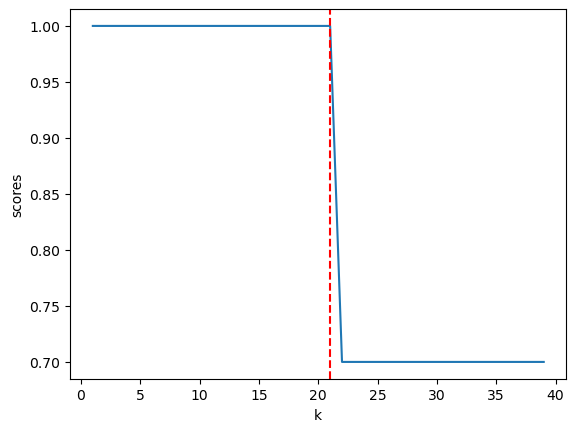

In [184]:
# x축 k, y축 점수
plt.plot(range(1,40), scores)
plt.xlabel('k')
plt.ylabel('scores')
plt.axvline(points[0]-1,0.0,1.0,color='red',linestyle='dashed')
plt.show()


[7] 예측 하기 ===> 학습/훈련과 테스트에 사용되지 않은 데이터 사용
- 주의 : 입력데이터 --> 2D 

In [185]:
new_data = pd.DataFrame([[413,27.8]], columns=['Weight','Length'])
new_data

,Weight,Length
0,413,27.8


In [186]:
new_data_scaled= mmSclaer.transform(new_data)
new_data_scaled

array([[0.40904057, 0.57692308]])

In [187]:
# 임의의 새로운 데이터의 예측
model.predict(new_data_scaled)

array([0], dtype=int64)

In [188]:
#### 최근접한 K개 데이터 찾기
distance, index=model.kneighbors(new_data_scaled)

In [189]:
neighbors=index.reshape(-1).tolist()
neighbors, twoDF.iloc[neighbors]

([25,
  22,
  21,
  0,
  6,
  17,
  29,
  10,
  2,
  36,
  12,
  37,
  33,
  30,
  23,
  31,
  11,
  9,
  14,
  24,
  26,
  16,
  5,
  35,
  3,
  20,
  18,
  4,
  1,
  27,
  7,
  28,
  15,
  19,
  13,
  38,
  32,
  34,
  8],
    Species  Weight  Length  FCode
 25   Bream   725.0    35.0      0
 22   Bream   620.0    34.5      0
 21   Bream   685.0    34.0      0
 0    Bream   242.0    25.4      0
 6    Bream   500.0    29.7      0
 17   Bream   700.0    33.0      0
 29   Bream  1000.0    37.0      0
 10   Bream   475.0    31.0      0
 2    Bream   340.0    26.5      0
 36   Smelt     7.5    10.5      1
 12   Bream   500.0    31.5      0
 37   Smelt     7.0    10.6      1
 33   Bream   975.0    41.0      0
 30   Bream   920.0    38.5      0
 23   Bream   680.0    35.0      0
 31   Bream   955.0    38.5      0
 11   Bream   500.0    31.0      0
 9    Bream   500.0    30.7      0
 14   Bream   600.0    32.0      0
 24   Bream   700.0    35.0      0
 26   Bream   720.0    35.0      0
 16  

In [190]:
X_train_scaled[neighbors]

array([[4.26155240e-01, 6.15384615e-01],
       [3.58703312e-01, 6.15384615e-01],
       [4.46290144e-01, 6.37820513e-01],
       [3.85885432e-01, 6.47435897e-01],
       [4.46290144e-01, 6.47435897e-01],
       [3.35548173e-01, 5.35256410e-01],
       [4.96627404e-01, 6.37820513e-01],
       [4.71458774e-01, 6.79487179e-01],
       [2.85210913e-01, 5.28846154e-01],
       [4.96627404e-01, 6.79487179e-01],
       [4.96627404e-01, 6.95512821e-01],
       [3.35548173e-01, 7.11538462e-01],
       [5.97301923e-01, 7.11538462e-01],
       [5.72133293e-01, 7.75641026e-01],
       [6.07369375e-01, 7.59615385e-01],
       [6.17436827e-01, 7.91666667e-01],
       [6.47639183e-01, 7.59615385e-01],
       [6.97976442e-01, 7.43589744e-01],
       [6.82875264e-01, 7.75641026e-01],
       [6.77841538e-01, 8.07692308e-01],
       [6.97976442e-01, 8.07692308e-01],
       [7.18111346e-01, 8.07692308e-01],
       [1.32890365e-02, 1.66666667e-01],
       [9.19460385e-01, 9.19871795e-01],
       [5.537098

In [191]:
k_weight=X_train_scaled[neighbors][:,0]
k_length = X_train_scaled[neighbors][:,1]
print(new_data_scaled)
print(k_weight,k_length,sep='\n')

[[0.40904057 0.57692308]]
[4.26155240e-01 3.58703312e-01 4.46290144e-01 3.85885432e-01
 4.46290144e-01 3.35548173e-01 4.96627404e-01 4.71458774e-01
 2.85210913e-01 4.96627404e-01 4.96627404e-01 3.35548173e-01
 5.97301923e-01 5.72133293e-01 6.07369375e-01 6.17436827e-01
 6.47639183e-01 6.97976442e-01 6.82875264e-01 6.77841538e-01
 6.97976442e-01 7.18111346e-01 1.32890365e-02 9.19460385e-01
 5.53709856e-03 6.74519279e-03 9.24494111e-01 9.54696466e-01
 3.12091010e-03 3.22158462e-03 1.00000000e+00 2.01349039e-03
 3.12091010e-03 3.02023558e-03 3.02023558e-04 9.49662740e-01
 8.05396154e-04 9.74831370e-01 0.00000000e+00]
[0.61538462 0.61538462 0.63782051 0.6474359  0.6474359  0.53525641
 0.63782051 0.67948718 0.52884615 0.67948718 0.69551282 0.71153846
 0.71153846 0.77564103 0.75961538 0.79166667 0.75961538 0.74358974
 0.77564103 0.80769231 0.80769231 0.80769231 0.16666667 0.91987179
 0.1025641  0.08333333 0.95192308 0.91987179 0.07051282 0.06410256
 0.87179487 0.04807692 0.04487179 0.0384615

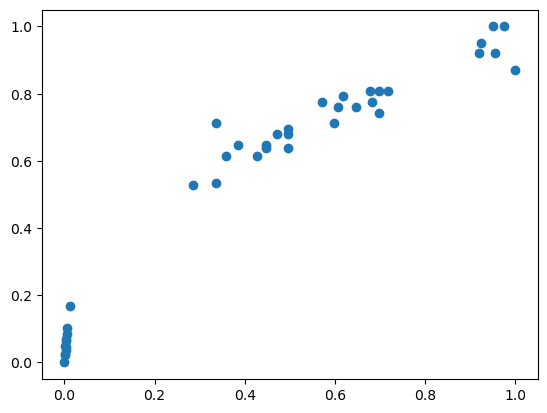

In [192]:
### 시각화로 확인 
# 도미(Bream), 방어(Smelt) 시각화, 2개 피쳐 Weight, Length로 Bream,Smelt 분류 가능
plt.scatter(X_train_scaled[:,0],X_train_scaled[:,1])
# plt.scatter(twoDF.loc[35:,'Weight'],twoDF.loc[35:,'Length'])  # Smelt만 시각화
# plt.plot(new_data_scaled[0,0], new_data_scaled[0,1], 'r^')
# plt.scatter(k_weight,k_length)

plt.show()